In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import warnings
warnings.filterwarnings("ignore")

In [2]:
human = pd.read_table("human.txt")
chimp = pd.read_table("chimpanzee.txt")
dog = pd.read_table("dog.txt")

# ✅ Step 3: Labeling (Human = 1, Others = 0)
human["label"] = 1
chimp["label"] = 0
dog["label"] = 0

# ✅ Step 4: Combine Data
data = pd.concat([human, chimp, dog])

# ✅ Step 5: K-mer Tokenization Function (6-mers)
def get_kmers(sequence, size=6):
    return ' '.join([sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)])

data["kmers"] = data["sequence"].apply(lambda x: get_kmers(x, size=6))

In [3]:
human.head()

,sequence,class,label
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4,1
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4,1
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,1
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,1
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3,1


In [4]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data["kmers"])
y = data["label"].values

# ✅ Step 7: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# ✅ Step 8: SMOTE Oversampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Create a smaller subset for grid search (e.g., 10% or a fixed number like 10000)
# Use stratify to maintain class proportions
subset_size = min(10000, int(0.2 * len(y_resampled))) # Example: 20% or 10k samples max
if subset_size < len(y_resampled):
    X_subset, _, y_subset, _ = train_test_split(
        X_resampled, y_resampled, train_size=subset_size, stratify=y_resampled, random_state=42
    )
    print(f"Using a subset of {len(y_subset)} samples for grid search.")
else:
    X_subset, y_subset = X_resampled, y_resampled # Use full data if it's already small
    print("Dataset small enough, using full data for grid search.")

# Updated parameter grid based on the best parameter from the subset search
svm_params = {
    'C': [0.1, 1, 10, 100],            # Expanding the range of C
    'kernel': ['rbf', 'linear'],       # Keeping linear and rbf as the best kernel
    'gamma': ['scale', 'auto', 0.01, 0.1],  # Additional values for gamma
    'degree': [3, 4],                  # For polynomial kernel, add degree
    'class_weight': [None, 'balanced'] # Class balancing option
}

# Grid search setup
svm_grid = GridSearchCV(
    SVC(probability=False, cache_size=500),  # Keep probability=False for speed during search
    svm_params,
    cv=3,  # Maybe reduce CV folds for the subset search
    scoring='accuracy',
    n_jobs=-1
)

print("Starting Grid Search on subset...")
svm_grid.fit(X_subset, y_subset)
print("Best parameters found on subset: ", svm_grid.best_params_)
print("Best accuracy found on subset: ", svm_grid.best_score_)

# Now train the final best model on the full resampled data
print("Training final model on full resampled data...")
best_svm = SVC(probability=True, **svm_grid.best_params_, cache_size=500) # Add probability=True back if needed
best_svm.fit(X_resampled, y_resampled)
print("Final model trained.")


Using a subset of 1401 samples for grid search.
Starting Grid Search on subset...
Best parameters found on subset:  {'C': 1, 'class_weight': None, 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf'}
Best accuracy found on subset:  0.7044967880085653
Training final model on full resampled data...
Final model trained.


In [6]:
xgb_params = {'max_depth': [3, 5], 'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1]}
xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgb_params, cv=5, scoring='accuracy', n_jobs=-1)
xgb_grid.fit(X_resampled, y_resampled)
best_xgb = xgb_grid.best_estimator_


📊 Best SVM Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.68      0.57       501
           1       0.76      0.58      0.66       876

    accuracy                           0.62      1377
   macro avg       0.62      0.63      0.62      1377
weighted avg       0.66      0.62      0.63      1377



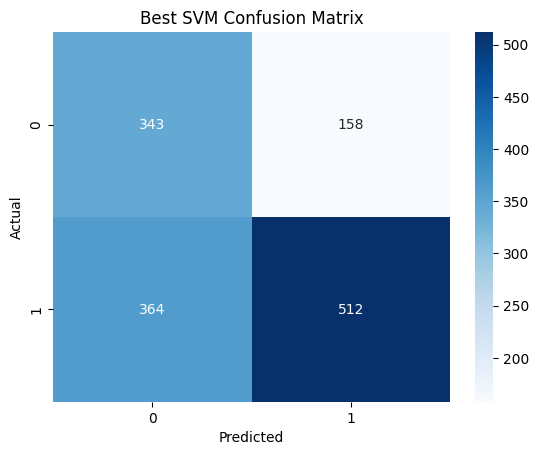

In [ ]:
def evaluate_model(name, model):
    y_pred = model.predict(X_test)
    print(f"\n📊 {name} Classification Report:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# ✅ Step 11: Evaluate Tuned Models
evaluate_model("Best SVM", best_svm)
# evaluate_model("Best XGBoost", best_xgb)


In [ ]:
plt.figure(figsize=(8,6))
models = {"SVM": best_svm, "XGBoost": best_xgb}
for name, model in models.items():
    probs = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# ✅ Step 13: Final Accuracy
print("\n📌 Final Accuracy Comparison:")
print(f"Best SVM: {accuracy_score(y_test, best_svm.predict(X_test)):.4f}")
print(f"Best XGBoost: {accuracy_score(y_test, best_xgb.predict(X_test)):.4f}")

NameError: name 'plt' is not defined